![Model img](https://drive.google.com/uc?id=1bjPVCUHribVvMgB8hKjt3AZgGLCBmISB)

# Download data

In [0]:
!wget -qq "https://www.dropbox.com/s/c1pzdacnzhvi6pm/histos_tba.20.npz"

# Preprocess

In [0]:
import numpy as np
from random import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

**Load files**

In [0]:
X = np.load("/content/histos_tba.20.npz")['variables']
y = np.load("/content/histos_tba.20.npz")['parameters'][:,0]

**Convert to degrees**

In [0]:
phi = X[:,:5]/60
theta = X[:,12:17]*0.285
z = np.array([5.70,6.90,6.90,7.90,10.00]) ## As given in figure-2

**Standarize features** which are not coordinates

In [5]:
x4 = np.concatenate([X[:,5:12],X[:,17:]],axis = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x4 = scaler.fit_transform(x4)
x4 = x4[:,scaler.var_>0]
print("Shape after removing features with var=0 :",x4.shape)
x4 = np.nan_to_num(x4, nan = 0.0)
np.save("/content/x4.npy",x4)

Shape after removing features with var=0 : (3272341, 60)


### Distribution of phi and theta

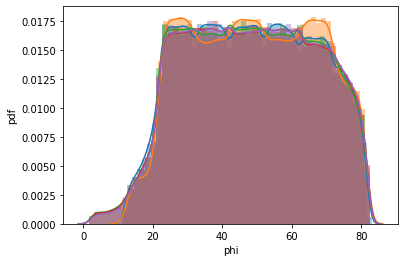

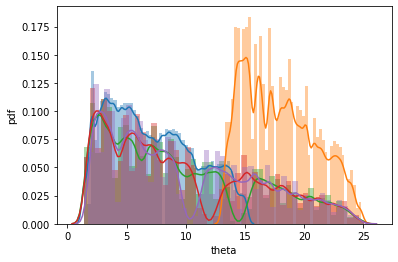

In [6]:
for i in range(5):
    sns.distplot(phi[:,i])
plt.xlabel("phi")
plt.ylabel("pdf")
plt.show()

for i in range(5):
    sns.distplot(theta[:,i])
plt.xlabel("theta")
plt.ylabel("pdf")
plt.show()

**Convert phi and theta to radians**

In [0]:
phi = np.radians(phi)
theta = np.radians(theta)

### Spherical to Cartesian coordinates



In [8]:
"""
r = z/cos(theta)
x = r*sin(theta)*cos(phi)
y = r*sin(theta)*sin(phi)
"""

r = np.divide(z,np.cos(theta))
a = np.multiply(r,np.sin(theta))
x = np.multiply(a,np.cos(phi))
y = np.multiply(a,np.sin(phi))

r.shape, x.shape, y.shape

((3272341, 5), (3272341, 5), (3272341, 5))

**Get max and min values of coordinates**

In [9]:
x = np.nan_to_num(x,nan = -np.float("Inf"))
y = np.nan_to_num(y,nan = -np.float("Inf"))

print(x.max(), y.max(), z.max())

x = np.nan_to_num(x,neginf = np.float("Inf"))
y = np.nan_to_num(y,neginf = np.float("Inf"))

print(x.min(), y.min(), z.min())

x = np.nan_to_num(x,posinf = -np.float("Inf"))
y = np.nan_to_num(y,posinf = -np.float("Inf"))

4.522240300109081 4.57684834002115 10.0
0.023492740859524405 0.005591111572611814 5.7


**Get rows with atleast one non-nan entry**




In [0]:
rows = np.sum(x==-np.float("Inf"),axis = 1)!=5

# Projection of paths on xy, yz, and zx planes as Images 

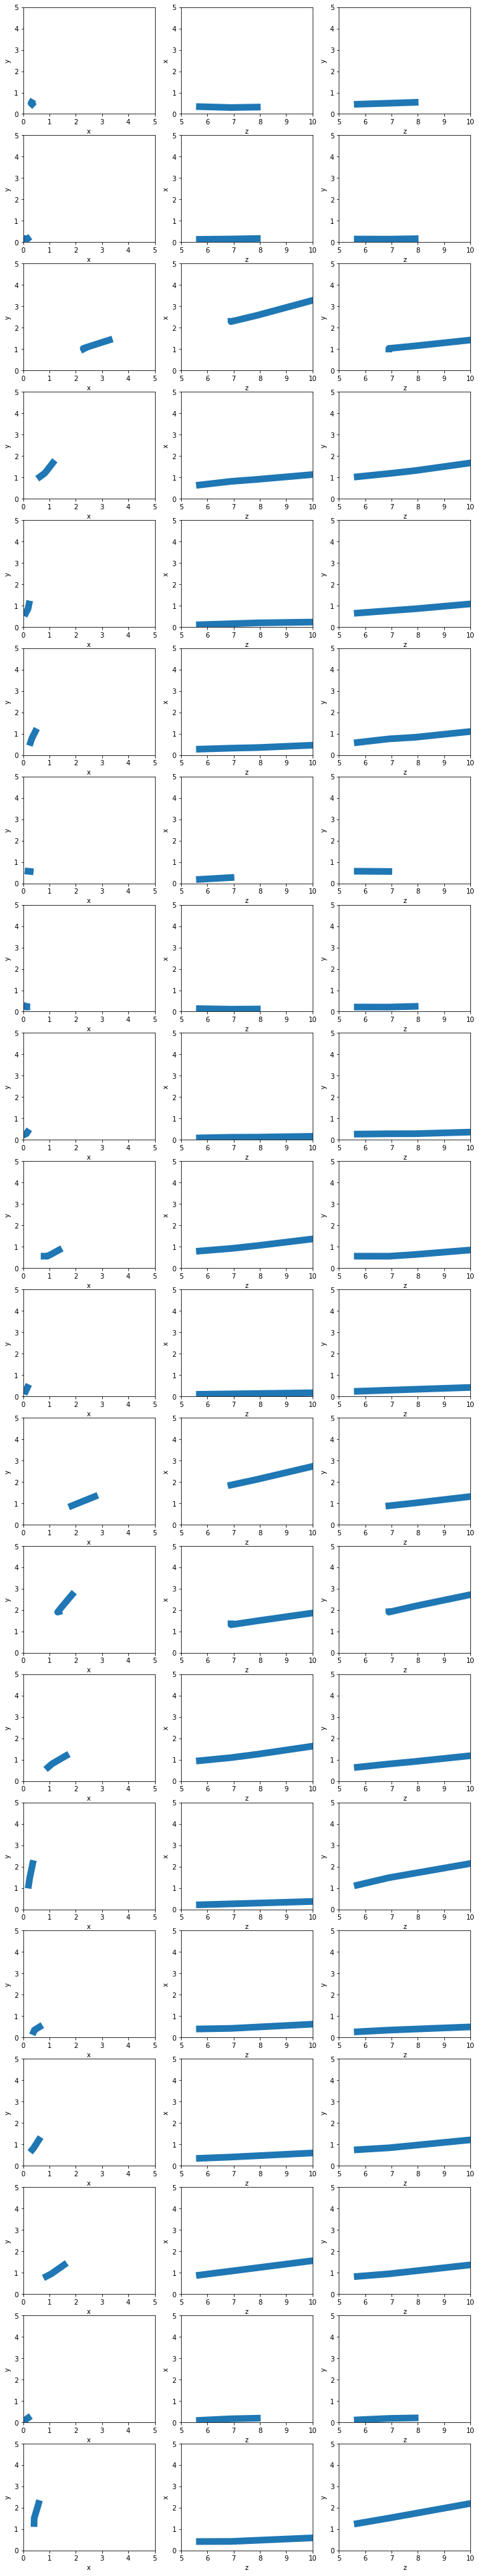

In [11]:
fig, ax = plt.subplots(20,3,figsize=(12,70))

for i in range(20):
  ax[i][0].plot(x[i,x[i]>-1000],y[i,x[i]>-1000],linewidth=10)
  ax[i][0].set_xlim(0,5)
  ax[i][0].set_ylim(0,5)
  ax[i][0].set_xlabel('x')
  ax[i][0].set_ylabel('y')
  ax[i][1].plot(z[x[i]>-1000],x[i,x[i]>-1000],linewidth=10)
  ax[i][1].set_ylim(0,5)
  ax[i][1].set_xlim(5,10)
  ax[i][1].set_ylabel('x')
  ax[i][1].set_xlabel('z')
  ax[i][2].plot(z[x[i]>-1000],y[i,x[i]>-1000],linewidth=10)
  ax[i][2].set_ylim(0,5)
  ax[i][2].set_xlim(5,10)
  ax[i][2].set_ylabel('y')
  ax[i][2].set_xlabel('z')

### Save images

In [12]:
!mkdir /content/images
%cd /content/images

#### Uncomment line given below to train on complete dataset#####
# for i in tqdm(range(int(len(X)))):

for i in tqdm(range(1500)):
  plt.figure(figsize=(3, 3))
  plt.plot(x[i,x[i]>-1000],y[i,x[i]>-1000],linewidth=10)
  plt.xlim(0,5)
  plt.ylim(0,5)
  plt.axis('off')
  plt.savefig(str(i)+'_xy'+'.png',bbox_inches='tight', pad_inches=0)
  plt.close()
  plt.figure(figsize=(3, 3))
  plt.plot(z[x[i]>-1000],x[i,x[i]>-1000],linewidth=10)
  plt.ylim(0,5)
  plt.xlim(5,10)
  plt.axis('off')
  plt.savefig(str(i)+'_xz'+'.png',bbox_inches='tight', pad_inches=0)
  plt.close()
  plt.figure(figsize=(3, 3))
  plt.plot(z[x[i]>-1000],y[i,x[i]>-1000],linewidth=10)
  plt.ylim(0,5)
  plt.xlim(5,10)
  plt.axis('off')
  plt.savefig(str(i)+'_yz'+'.png',bbox_inches='tight', pad_inches=0)
  plt.close()

  0%|          | 1/1500 [00:00<02:31,  9.89it/s]

/content/images


100%|██████████| 1500/1500 [02:39<00:00, 10.32it/s]


# DataGenerator

**Methods** - 
<br><br>

len : returns number of samples for given generator(i.e. train, val or test)<br><br>
on_epoch_end : shuffle  indexes if shuffle is true<br><br>
data_generation : generates a batch (i.e. [x1, x2, x3, x4], y ), where <br>dim(x1) = (batch_size, 64, 64, 1) <br>dim(x2) = (batch_size, 64, 64, 1)<br>dim(x3) = (batch_size, 64, 64, 1) <br>dim(x4) = (batch_size, 60)<br>dim(y) = (batch_size, 1)<br><br>
Images are pre-processed as (Image - 128)/128 and other features are standarized

In [13]:
import numpy as np
import tensorflow.keras as keras
import glob
import cv2

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size=32, shuffle=True, mode='train'):
        assert mode in ['train', 'val', 'test']
        self.shuffle = shuffle
        if mode == 'train':
            self.indexes = np.array(list(range(int(len(glob.glob("/content/images/*.png"))//3*0.8))))
        elif mode == 'val': 
            self.indexes = np.array(list(range(int(len(glob.glob("/content/images/*.png"))//3*0.8),int(len(glob.glob("/content/images/*.png"))//3*0.9))))
        else:
            self.indexes = np.array(list(range(int(len(glob.glob("/content/images/*.png"))//3*0.9),int(len(glob.glob("/content/images/*.png"))//3))))
        self.labels = np.load("/content/histos_tba.20.npz")['parameters'][:,0]
        self.on_epoch_end()
        self.batch_size = batch_size
        self.x4 = np.load("/content/x4.npy")

    def __len__(self):
        return int(np.floor(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        [x1,x2,x3,x4], y = self.__data_generation(indexes)

        return [x1,x2,x3,x4], y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        def read_img(ID,t):
            R = cv2.imread(str(ID)+'_'+t+'.png')
            R = cv2.resize(R, (64,64))
            R = (R[:,:,0] + R[:,:,1] + R[:,:,2])/3
            R = (R - 128)/128
            return R.reshape(64,64,1)
        x1 = np.zeros((self.batch_size,64,64,1))
        x2 = np.zeros((self.batch_size,64,64,1))
        x3 = np.zeros((self.batch_size,64,64,1))
        x4 = np.zeros((self.batch_size,60))
        y = np.zeros((self.batch_size,1))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            x1[i,] = read_img(ID, 'xy')
            x2[i,] = read_img(ID, 'xz')
            x3[i,] = read_img(ID, 'yz')
            x4[i,] = self.x4[ID]

            # Store class
            y[i] = self.labels[ID]

        return [x1,x2,x3,x4],y


Generator Objects

In [0]:
train_generator = DataGenerator(mode = 'train')
val_generator = DataGenerator(mode = 'val')
test_generator = DataGenerator(mode = 'test')

Example

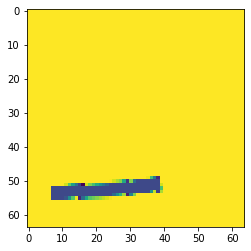

In [15]:
[x1,x2,x3,x4],y = val_generator[2]
plt.imshow(x2[1].reshape(64,64))

# Model

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [0]:
def model():

################# CONV 1 ########################
    I1 = layers.Input((64, 64, 1))
    x1 = layers.Conv2D(32,3,padding='same')(I1)
    x1 = layers.BatchNormalization()(x1)
    x1_ = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(32,3,padding='same')(x1_)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = x1 + x1_                                                        ###### Skip connection
    x1 = layers.GlobalAveragePooling2D()(x1)

################# CONV 2 ########################
    I2 = layers.Input((64, 64, 1))
    x2 = layers.Conv2D(32,3,padding='same')(I2)
    x2 = layers.BatchNormalization()(x2)
    x2_ = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(32,3,padding='same')(x2_)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = x2 + x2_                                                        ###### Skip connection
    x2 = layers.GlobalAveragePooling2D()(x2)

################# CONV 3 ########################
    I3 = layers.Input((64, 64, 1))
    x3 = layers.Conv2D(32,3,padding='same')(I3)
    x3 = layers.BatchNormalization()(x3)
    x3_ = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(32,3,padding='same')(x3_)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = x3 + x3_                                                        ###### Skip connection
    x3 = layers.GlobalAveragePooling2D()(x3)

################# Dense #########################
    I4 = layers.Input(shape=(60))
    x4 = layers.Dense(128,activation='relu')(I4)
    x4 = layers.Dense(32,activation='relu')(x4)

############### Concatenate #####################
    x = layers.concatenate([x1,x2,x3,x4])

################### DNN #########################
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

################## Output #######################
    O = layers.Dense(1)(x)

##################################################
    model = Model([I1,I2,I3,I4],O)
##################################################

    model.compile(optimizer=Adam(0.01), loss='mse', metrics=['mse'])
    model.summary()
    return model

In [18]:
model = model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
_____________

# Train and Save

In [0]:
check_point = ModelCheckpoint('/content/model.hdf5',monitor='val_loss',verbose=True, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

In [20]:
history = model.fit_generator(train_generator , epochs=25, validation_data=val_generator, verbose=1,callbacks=[check_point,early_stop,reduce_lr])

Epoch 1/25
 4/37 [==>...........................] - ETA: 14s - loss: 0.1429 - mean_squared_error: 0.1429
Epoch 00001: val_loss improved from inf to 0.14287, saving model to /content/model.hdf5
37/37 [==============================] - 57s 2s/step - loss: 0.3808 - mean_squared_error: 0.3808 - val_loss: 0.1429 - val_mean_squared_error: 0.1429
Epoch 2/25
 4/37 [==>...........................] - ETA: 13s - loss: 0.0269 - mean_squared_error: 0.0269
Epoch 00002: val_loss improved from 0.14287 to 0.02692, saving model to /content/model.hdf5
37/37 [==============================] - 53s 1s/step - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 0.0269 - val_mean_squared_error: 0.0269
Epoch 3/25
 4/37 [==>...........................] - ETA: 13s - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 00003: val_loss improved from 0.02692 to 0.01949, saving model to /content/model.hdf5
37/37 [==============================] - 53s 1s/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0195

In [21]:
model.evaluate_generator(test_generator)

[0.006298528169281781, 0.006298528]